I found out that there are multiple wrongly labeled objects in MNIST. Discovering this made a massive boost in the achieved accuracy.

- Accuracy before datacleaning: 0.9762714285714286

In [39]:
import matplotlib.pyplot as plt
from torch.optim import Adam
from cleanlab.filter import find_label_issues

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import numpy as np
import time

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device)

cpu


In [7]:
mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy() # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range
X = X.reshape(len(X), 1, 28, 28)  # reshape into [N, C, H, W] for PyTorch
labels = mnist.target.astype("int64").to_numpy()

In [137]:
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kerneal_size=2, stride=2),

            nn.Conv2d(6, 16, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(400, 200),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(200, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [65]:
model_skorch = NeuralNetClassifier(ClassifierModule)

In [19]:
num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8191       0.9117        0.3289  5.1524
      2        0.2747       0.9383        0.2060  4.6721
      3        0.1951       0.9516        0.1607  4.5821
      4        0.1598       0.9585        0.1362  4.5761
      5        0.1357       0.9633        0.1206  4.5637
      6        0.1222       0.9664        0.1091  4.5825
      7        0.1094       0.9689        0.1013  4.5879
      8        0.0990       0.9705        0.0947  4.5933
      9        0.0935       0.9729        0.0887  4.5756
     10        0.0853       0.9735        0.0857  4.5553
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7135       0.9348        0.2604  4.5557
      2        0.2305       0.9511        0.1748  4.5537
      3        0.1696       0.9600        0.1424  4.5471
      4        0.1390       0.9

In [20]:
predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(labels, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9764857142857143


In [21]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    labels,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 138 label issues.
Top 15 most likely label errors: 
 [59915 24798 28556  2720  8729 61014  7010   902 53216    80  2676  8200
 63767 12183 31134]


In [22]:
print(len(X), len(labels))
print(X.shape, labels.shape)
new_X = np.delete(X, ranked_label_issues, axis=0)
new_labels = np.delete(labels, ranked_label_issues, axis=0)
print(len(new_X), len(new_labels))

70000 70000
(70000, 1, 28, 28) (70000,)
69862 69862


In [36]:
num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    new_X,
    new_labels,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8432       0.9179        0.3117  4.5077
      2        0.2541       0.9427        0.1863  4.6991
      3        0.1786       0.9547        0.1418  4.8610
      4        0.1429       0.9616        0.1179  4.5875
      5        0.1233       0.9652        0.1031  4.5515
      6        0.1090       0.9698        0.0921  4.5964
      7        0.0992       0.9721        0.0840  4.7270
      8        0.0884       0.9739        0.0779  4.8036
      9        0.0820       0.9755        0.0724  4.6150
     10        0.0760       0.9752        0.0696  4.5920
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8248       0.9232        0.2971  4.5099
      2        0.2648       0.9475        0.1833  4.5595
      3        0.1864       0.9573        0.1447  4.5511
      4        0.1518       0.9

In [ ]:
Xtr, Xdev, Ytr, Ydev = train_test_split(new_X, new_labels, test_size = 0.1)

In [139]:
model = ClassifierModule()
print(model.parameters())
optim = AdamW(model.parameters(), lr=1e-3)
losses = []
losses_test = []
losses_mean = []

<generator object Module.parameters at 0x2af660dd0>


In [140]:
with torch.no_grad():
    def evaluate():
        logits = model(Xdev)
        loss = F.cross_entropy(logits, Ydev)
        return loss

In [141]:
max_steps = 10000
batch_size = 64

model.train()

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    preds = model(Xb)
    loss = F.cross_entropy(preds, Yb)

    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 500 == 0:
        print(f"current step: {i}, loss: {loss.log10().item():.4f}")
        losses_test.append(evaluate())
    losses.append(loss.log10().item())

current step: 0, loss: 0.3624
current step: 500, loss: 0.1648
current step: 1000, loss: 0.1771
current step: 1500, loss: 0.1798
current step: 2000, loss: 0.1741
current step: 2500, loss: 0.1689
current step: 3000, loss: 0.1647
current step: 3500, loss: 0.1693
current step: 4000, loss: 0.1693
current step: 4500, loss: 0.1706
current step: 5000, loss: 0.1693
current step: 5500, loss: 0.1647
current step: 6000, loss: 0.1784
current step: 6500, loss: 0.1825
current step: 7000, loss: 0.1654
current step: 7500, loss: 0.1693
current step: 8000, loss: 0.1739
current step: 8500, loss: 0.1693
current step: 9000, loss: 0.1785
current step: 9500, loss: 0.1722


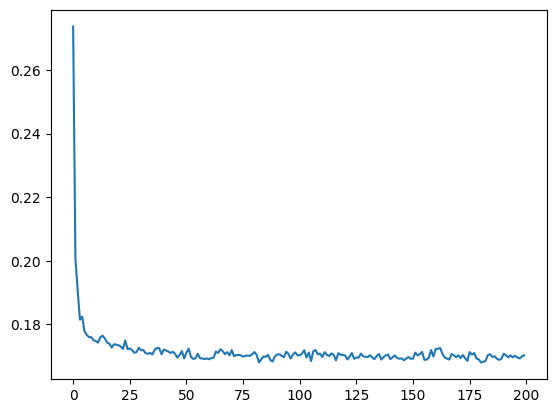

In [142]:
with torch.no_grad():
    losses_mean = []
    for i in range(max_steps // 50):
        mean = torch.mean(torch.tensor(losses[(i)*50:(i+1)*50]))
        losses_mean.append(mean)
    plt.plot(losses_mean)

In [143]:
with torch.no_grad():
    model.eval()
    logits = model(Xdev)
    _, predicted = torch.max(logits.data, 1)
    n_correct = (predicted == Ydev).sum().item()
    print(n_correct,  "/",  len(Xdev))
    print(100.0 * n_correct / len(Xdev))


6854 / 6987
98.09646486331759


### Performance log (first model is the best)

In [136]:
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Dropout(0.3),
            nn.Linear(200, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Performance on testset after 10000 steps: 98,612 % 

In [ ]:
# Additional Conv2d layer

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 48, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(48, 200),
            nn.ReLU(),

            nn.Dropout(0.3),
            nn.Linear(200, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Performance on testset after 10000 steps: 98.31 % 

In [124]:
# with one more hidden, fully connected layer
class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, 3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(400, 200),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(200, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Performance on testset after 10000 steps: 98.46%